## Import libraries

In [1]:
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings
import os
import glob
import cv2
import keras
import math

from keras import applications
from keras import layers
from keras.layers import Input,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model,Sequential
from matplotlib.pyplot import imshow
from keras.preprocessing import image

warnings.simplefilter('ignore')

## Mount the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change to the directory of interest

In [5]:
path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
os.chdir(path)

# List files in the directory
os.listdir(path)

['Viral_Pneumonia', 'Normal', 'COVID', 'Lung_Opacity']

## Show the sample image

(299, 299, 3)


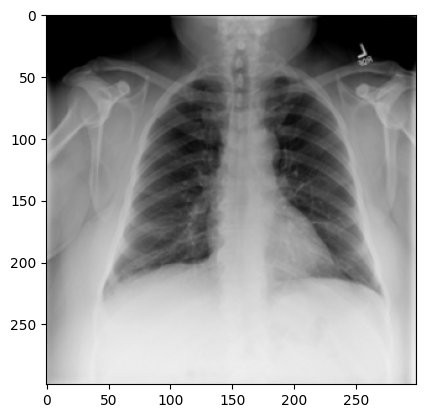

In [6]:
img = cv2.imread('//content/drive//MyDrive//COVID-19_Radiography_Dataset//Normal//Normal-25.png')
print(img.shape)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

## Get the list of directories

In [7]:
train_class=os.listdir('//content/drive//MyDrive//COVID-19_Radiography_Dataset//')
train_class

['Viral_Pneumonia', 'Normal', 'COVID', 'Lung_Opacity']

## Get the count of images as per class

In [8]:
count_dict1 = {}
img_dict1 = {}

for cls in train_class: 
    image_path = glob.glob(f'//content/drive//MyDrive//COVID-19_Radiography_Dataset//{cls}//*')
    count_dict1[cls] = len(image_path)

    if image_path:  # Check if image_path is not empty
        img_dict1[cls] = tf.keras.utils.load_img(random.choice(image_path))
count_dict1

{'Viral_Pneumonia': 1355, 'Normal': 10192, 'COVID': 3616, 'Lung_Opacity': 6012}

In [9]:
df1 = pd.DataFrame(data={'label':count_dict1.keys(),'count':count_dict1.values()})
df1

,label,count
0,Viral_Pneumonia,1355
1,Normal,10192
2,COVID,3616
3,Lung_Opacity,6012


## Classes count visualization

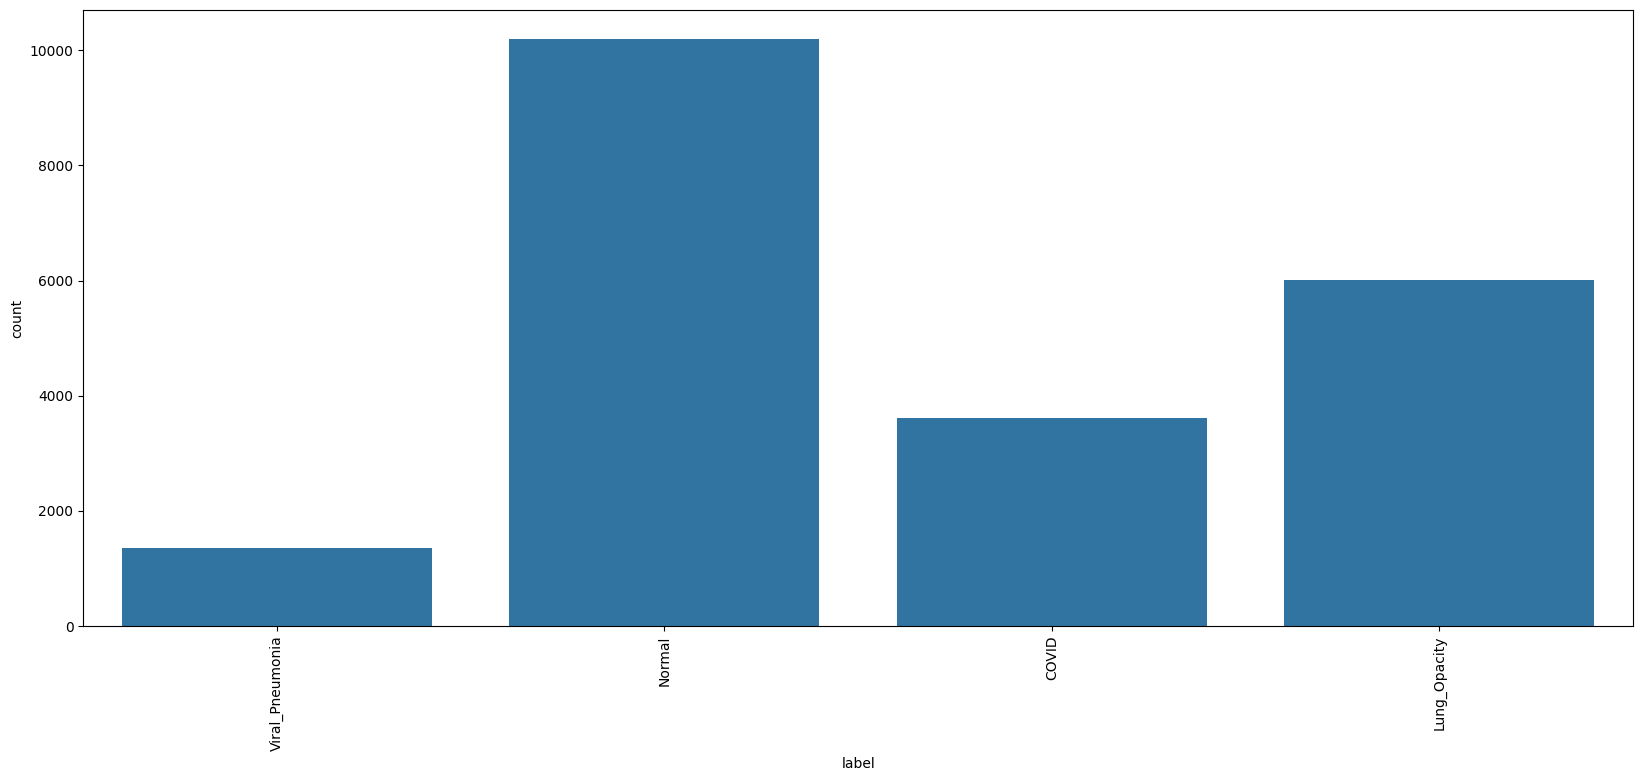

In [10]:
plt.figure(figsize=(20,8))
sns.barplot(x='label',y='count',data=df1)
plt.xticks(rotation=90)
plt.show()

## Show sample image of each class

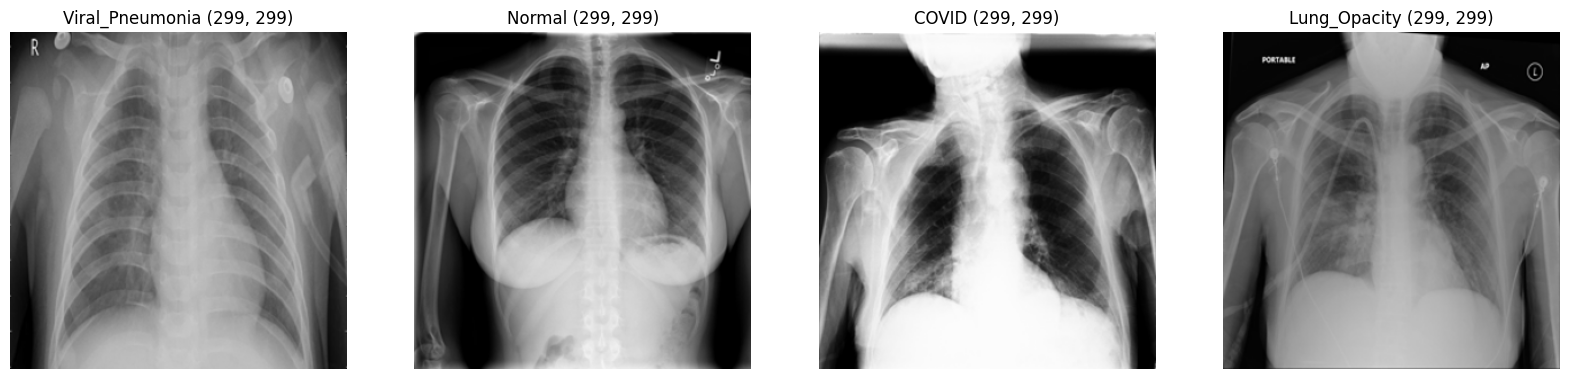

In [11]:
num_items = len(img_dict1)
num_cols = 4
num_rows = math.ceil(num_items / num_cols)

plt.figure(figsize=(20, 5 * num_rows))  # Adjust the figure size based on the number of rows

for id, (label, img) in enumerate(img_dict1.items()):
    plt.subplot(num_rows, num_cols, id + 1)
    plt.imshow(img)
    plt.title(f"{label} {img.size}")
    plt.axis('off')

## Get the data and split it into train and test

In [12]:
directory = "//content/drive//MyDrive//COVID-19_Radiography_Dataset//"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            label_mode='categorical',
            validation_split=0.2,
            subset="training",
            seed=1000,
        )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            validation_split=0.2,
            subset="validation",
            label_mode='categorical',
            seed=1000,
        )

Found 21175 files belonging to 4 classes.
Using 16940 files for training.
Found 21175 files belonging to 4 classes.
Using 4235 files for validation.


## Data pre-process

In [13]:
width = 224
height = 224
channels = 3

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(height, width),
    tf.keras.layers.Rescaling(1.0 / 255),

])

In [14]:
train_ds = train_data.map(lambda x,y:(data_preprocessing(x),y))

valid_ds = val_data.map(lambda x,y:(data_preprocessing(x),y))

In [15]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [16]:
valid_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

## Model build

### Sequential Model

In [17]:
model = Sequential()
# Convolutional layers with MaxPooling
model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# flatten the image into a 1D array using the Flatten layer
model.add(Flatten())
# Fully connected layers
# model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=32, activation="relu"))

# Output layer with 100 units and softmax activation for multi-class classification
model.add(Dense(units=4, activation="softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)      

In [19]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall'])

In [20]:
from keras.callbacks import EarlyStopping

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
batch_size = 50

In [23]:
history = model.fit(
          train_ds,
          epochs = 20,
          validation_data = valid_ds,
          validation_steps = 500 // batch_size,
          callbacks=early_stopping)

Epoch 1/20
530/530 [==============================] - 3044s 6s/step - loss: 0.6518 - accuracy: 0.7358 - precision: 0.7908 - recall: 0.6599 - val_loss: 0.5278 - val_accuracy: 0.8062 - val_precision: 0.8141 - val_recall: 0.7937
Epoch 2/20
530/530 [==============================] - 94s 176ms/step - loss: 0.3952 - accuracy: 0.8510 - precision: 0.8629 - recall: 0.8370 - val_loss: 0.3419 - val_accuracy: 0.8687 - val_precision: 0.8770 - val_recall: 0.8469
Epoch 3/20
530/530 [==============================] - 94s 175ms/step - loss: 0.3208 - accuracy: 0.8792 - precision: 0.8855 - recall: 0.8714 - val_loss: 0.3716 - val_accuracy: 0.8813 - val_precision: 0.8971 - val_recall: 0.8719
Epoch 4/20
530/530 [==============================] - 98s 182ms/step - loss: 0.2697 - accuracy: 0.8967 - precision: 0.9018 - recall: 0.8914 - val_loss: 0.3469 - val_accuracy: 0.8875 - val_precision: 0.8921 - val_recall: 0.8781
Epoch 5/20
530/530 [==============================] - 95s 176ms/step - loss: 0.2262 - accurac

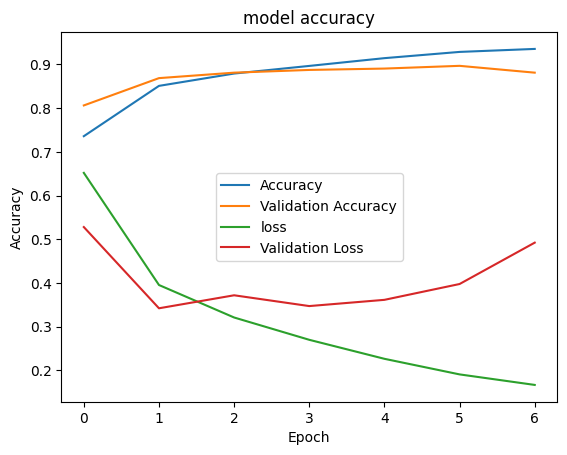

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

### Xception base model

## Import libaries

In [25]:
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.xception import Xception

In [26]:
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

83683744/83683744 [==============================] - 0s 0us/step


In [27]:
# Create a Sequential model
model_xception = Sequential()

# Adding the Xception base model
model_xception.add(base_model_xception)

# Adding Global Average Pooling 2D layer
model_xception.add(GlobalAveragePooling2D())

# Adding Dropout layer with a dropout rate of 0.5
model_xception.add(Dropout(0.25))

# Adding the final Dense layer with 100 units and 'softmax' activation
model_xception.add(Dense(4, activation='softmax'))

In [28]:
# Define RMSprop optimizer with specific parameters
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

In [29]:
model_xception.compile(optimizer='adam',loss='categorical_crossentropy'
                 ,metrics=['accuracy','Precision','Recall'])

In [30]:
model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20869676 (79.61 MB)
Trainable params: 20815148 (79.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [31]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
history2=model_xception.fit(
        train_ds,
        epochs=10,
        validation_data=valid_ds,
        callbacks=[early_stopping, reduce_lr])

Epoch 1/10
530/530 [==============================] - 300s 564ms/step - loss: 0.1754 - accuracy: 0.9396 - precision: 0.9423 - recall: 0.9368 - val_loss: 0.3226 - val_accuracy: 0.8841 - val_precision: 0.8870 - val_recall: 0.8824 - lr: 0.0010
Epoch 2/10
530/530 [==============================] - 311s 585ms/step - loss: 0.1363 - accuracy: 0.9512 - precision: 0.9527 - recall: 0.9492 - val_loss: 0.3437 - val_accuracy: 0.9039 - val_precision: 0.9052 - val_recall: 0.9022 - lr: 0.0010
Epoch 3/10
530/530 [==============================] - 292s 549ms/step - loss: 0.1096 - accuracy: 0.9607 - precision: 0.9620 - recall: 0.9596 - val_loss: 0.2365 - val_accuracy: 0.9341 - val_precision: 0.9349 - val_recall: 0.9329 - lr: 0.0010
Epoch 4/10
530/530 [==============================] - 311s 584ms/step - loss: 0.0914 - accuracy: 0.9675 - precision: 0.9687 - recall: 0.9668 - val_loss: 0.6284 - val_accuracy: 0.8434 - val_precision: 0.8465 - val_recall: 0.8413 - lr: 0.0010
Epoch 5/10
530/530 [================

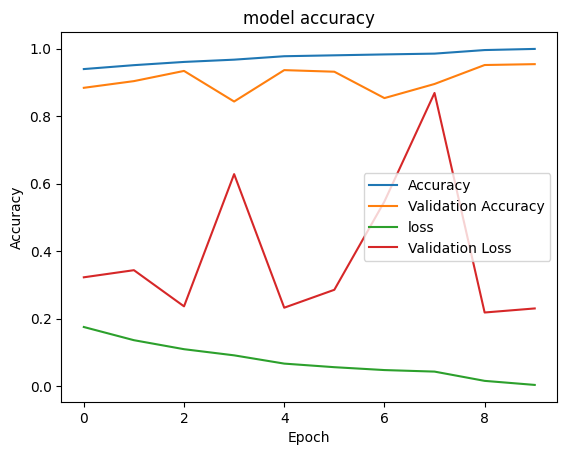

In [34]:
import matplotlib.pyplot as plt
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## I have used Sequential and xception base model and we got following result5

### Sequential Model :- Train : 93% and Test : 88%
### Xception base model :- Train : 99% and Test : 95%

## We have achieved best accuracy on both model